In [51]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [52]:
df = pd.read_csv('merge_train.csv',parse_dates=['date'])

In [53]:
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekdays'] = df['date'].dt.dayofweek  # 1 for weekend, 0 for weekday
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['EMA_4h'] = df['Price'].ewm(span=48, adjust=False).mean()


df['EMA_1d'] = df['Price'].ewm(span=288, adjust=False).mean()
df['Forecast_difference_0.5 hour future'] = df['Forecast_Roof_0.5 hour future'] - df['Forecast_Demand_0.5 hour future']
df["Forecast_ratio_0.5 hour future"] = df['Forecast_Roof_0.5 hour future'] / df['Forecast_Demand_0.5 hour future']
df.set_index('date', inplace=True)

In [54]:

df = df.drop(columns=['Region', 'Actual_Roof_OPOWER', 'Actual_Roof_LASTCHANGED'])


In [55]:
for feature in df.columns:
    
    df[f'{feature}_shift_1'] = df[feature].shift(1)
    df[f'{feature}_shift_6'] = df[feature].shift(6)
df = df.dropna()

C:\Users\Owner\AppData\Local\Temp\ipykernel_21508\1537105346.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_shift_1'] = df[feature].shift(1)
C:\Users\Owner\AppData\Local\Temp\ipykernel_21508\1537105346.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_shift_6'] = df[feature].shift(6)
C:\Users\Owner\AppData\Local\Temp\ipykernel_21508\1537105346.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

In [56]:
X = df.drop('Price', axis=1)
y = df['Price']

train_end_date = pd.to_datetime("2024-04-30 23:59:59")
val_end_date = pd.to_datetime("2024-05-31 23:59:59")
test_start_date = pd.to_datetime("2024-06-01 00:00:00")


X_train = X[X.index <= train_end_date]
X_val = X[(X.index > train_end_date) & (X.index <= val_end_date)]
X_test = X[X.index >= test_start_date]

y_train = y[y.index <= train_end_date]
y_val = y[(y.index > train_end_date) & (y.index <= val_end_date)]
y_test = y[y.index >= test_start_date]

In [57]:
import xgboost as xgb
def huber_approx_obj(preds, dtrain):
    d = preds - dtrain.get_label() #remove .get_labels() for sklearn
    h = 2  #h is delta in the graphic
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

def fair_obj(preds, dtrain):
    """y = c * abs(x) - c**2 * np.log(abs(x)/c + 1)"""
    x = preds - dtrain.get_label()
    c = 1
    den = abs(x) + c
    grad = c*x / den
    hess = c*c / den ** 2
    return grad, hess

params = {
    'max_depth': 10,
    'eta': 0.3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    "lambda":0.9,
    'random_state': 42
}

def custom_mae(preds, dtrain):
    labels = dtrain.get_label()
    return 'mae', np.mean(np.abs(preds - labels))


dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
dval = xgb.DMatrix(X_val.values, label=y_val.values)


model = xgb.train(
    params,
    dtrain = dtrain,
    evals=[(dtrain, 'train'), (dval, 'val')],
    obj = huber_approx_obj,
    feval=custom_mae,  
    num_boost_round=500,
    early_stopping_rounds=100,
    verbose_eval=True
)

c:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-rmse:5694.56242	train-mae:4352.70801	val-rmse:5994.71836	val-mae:4790.77197
[1]	train-rmse:887.36366	train-mae:199.97266	val-rmse:637.16843	val-mae:149.46651
[2]	train-rmse:1103.43605	train-mae:508.04437	val-rmse:848.46009	val-mae:404.15274
[3]	train-rmse:981.77224	train-mae:379.27676	val-rmse:775.24689	val-mae:345.80216
[4]	train-rmse:1042.99801	train-mae:399.49228	val-rmse:794.36495	val-mae:294.63333
[5]	train-rmse:950.70771	train-mae:304.12891	val-rmse:717.20778	val-mae:236.36142
[6]	train-rmse:1042.73727	train-mae:397.67075	val-rmse:767.82489	val-mae:268.32782
[7]	train-rmse:960.88870	train-mae:338.66568	val-rmse:698.95733	val-mae:236.33949
[8]	train-rmse:917.85211	train-mae:290.89246	val-rmse:673.83995	val-mae:209.50874
[9]	train-rmse:932.58537	train-mae:312.45731	val-rmse:679.32217	val-mae:213.66208
[10]	train-rmse:905.01862	train-mae:271.29340	val-rmse:662.88261	val-mae:201.06430
[11]	train-rmse:893.49401	train-mae:257.17905	val-rmse:652.83444	val-mae:189.94365
[12]	tr

In [58]:
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 112446.3894454565
Mean Absolute Error: 113.09251907526505
Root Mean Squared Error: 335.3302692055349


Top 10 features:
            Feature  Importance
52    Price_shift_1      4351.0
53    Price_shift_6      2601.0
46           EMA_4h      2063.0
144  EMA_4h_shift_1      1336.0
0            Demand      1322.0
45           minute      1295.0
145  EMA_4h_shift_6      1248.0
143  minute_shift_6      1203.0
47           EMA_1d      1095.0
142  minute_shift_1      1080.0


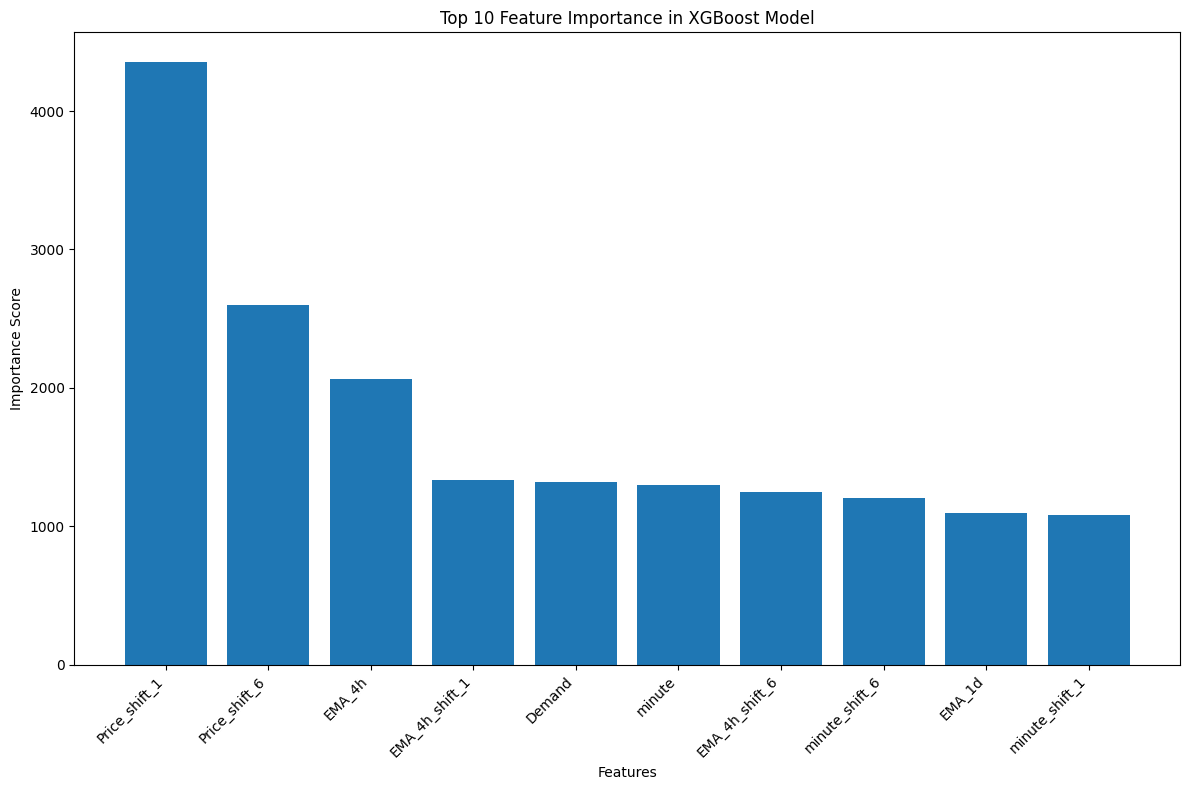

<Figure size 1200x800 with 0 Axes>

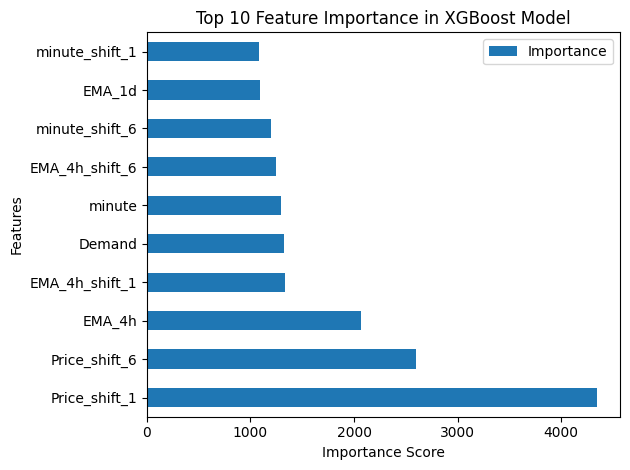

In [65]:





importance = model.get_score(importance_type='weight')


importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)


original_feature_names = X_test.columns


feature_name_map = {f'f{i}': name for i, name in enumerate(original_feature_names)}


importance_df['Feature'] = importance_df['Feature'].map(feature_name_map)


print("Top 10 features:")
print(importance_df.head(10))

plt.figure(figsize=(12, 8))
plt.bar(importance_df['Feature'].head(10), importance_df['Importance'].head(10))
plt.title('Top 10 Feature Importance in XGBoost Model')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
importance_df.head(10).plot(x='Feature', y='Importance', kind='barh')
plt.title('Top 10 Feature Importance in XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

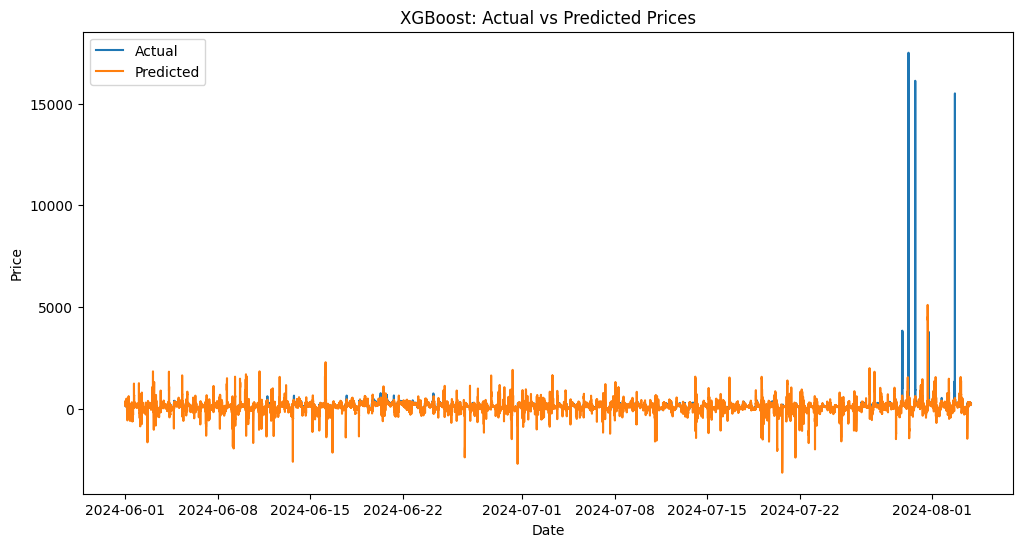

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('XGBoost: Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

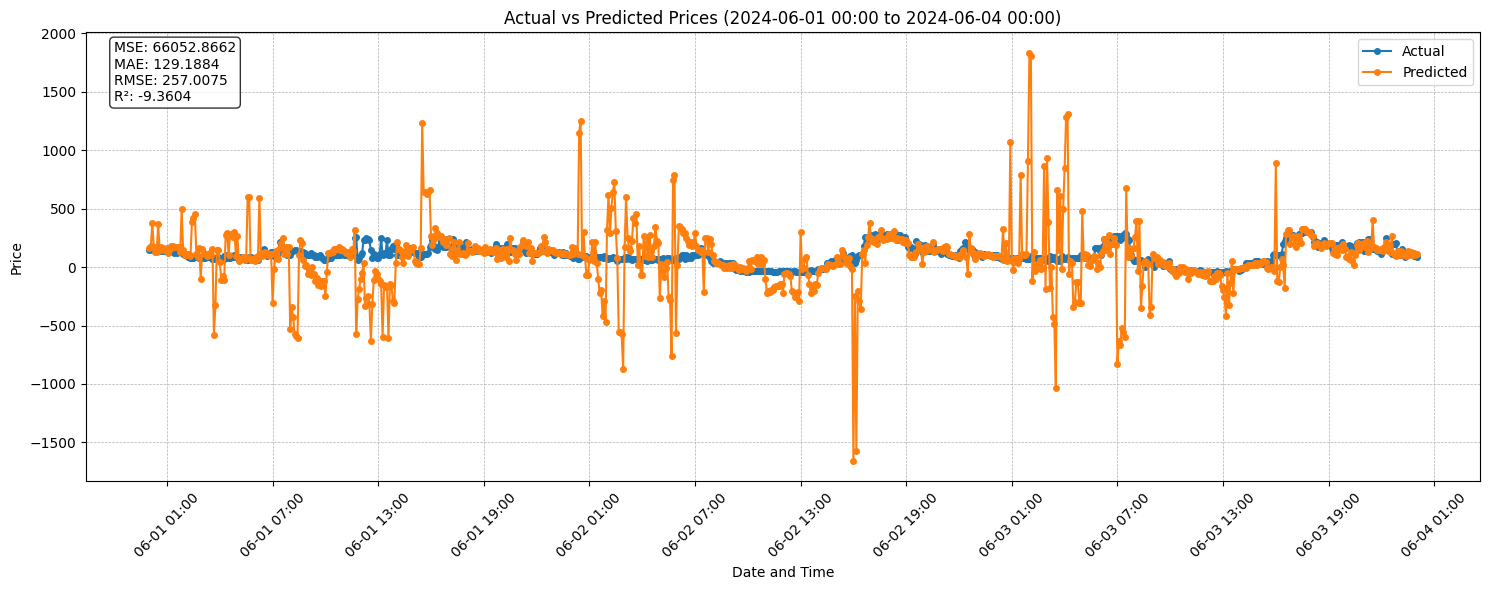

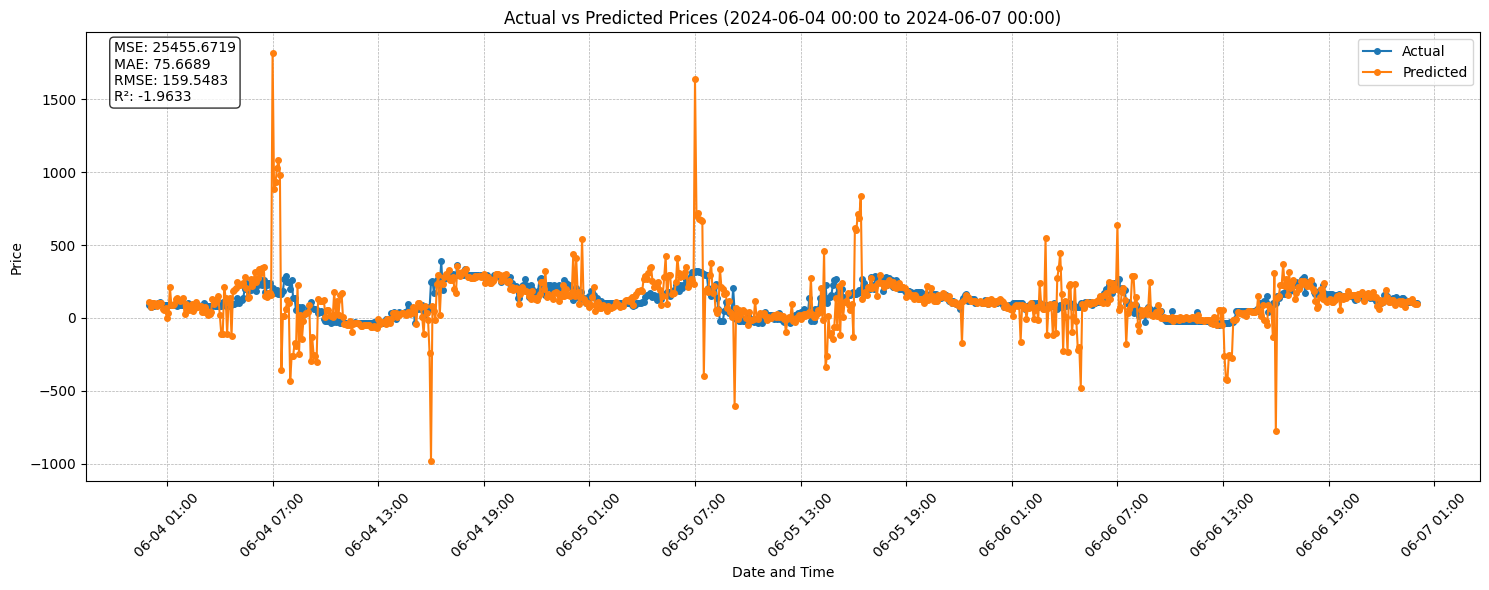

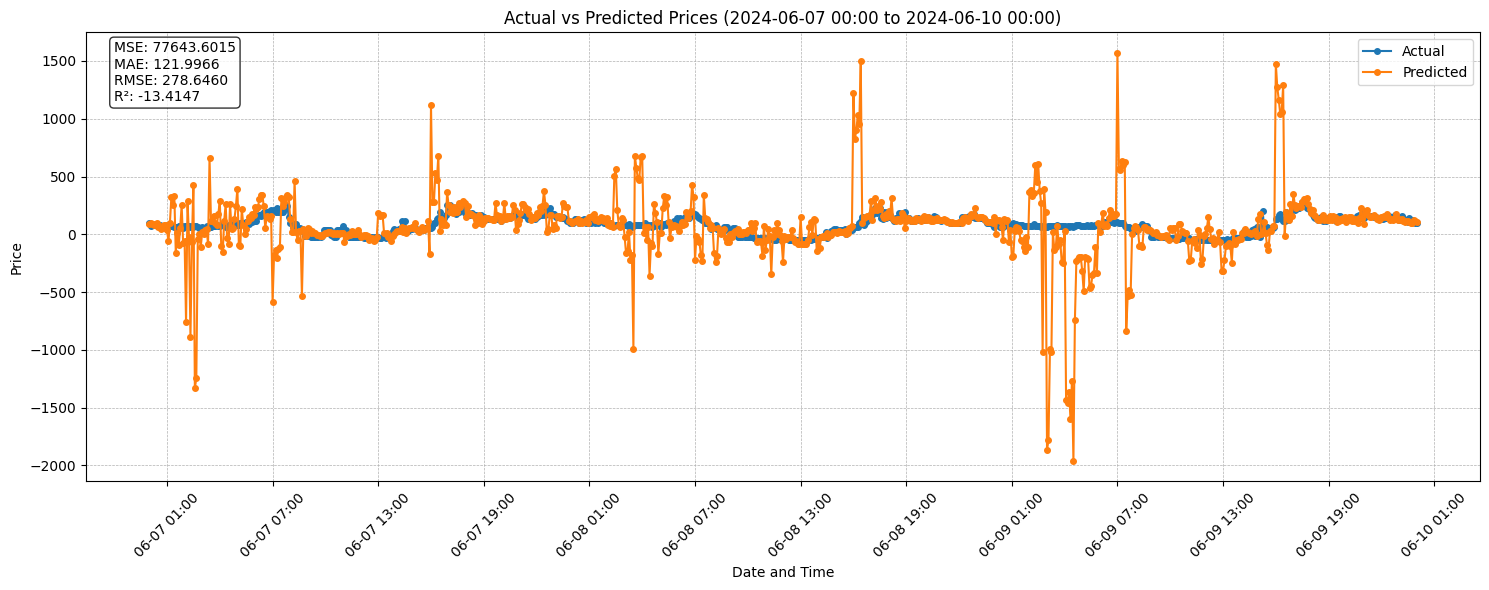

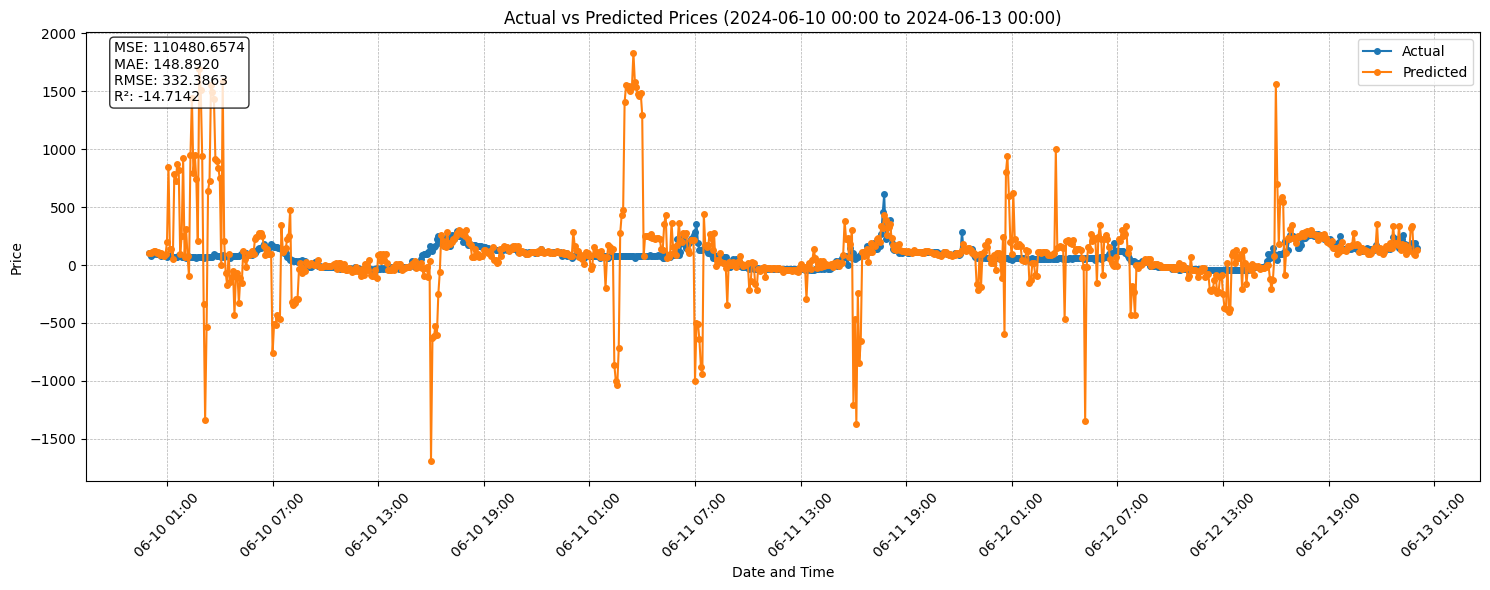

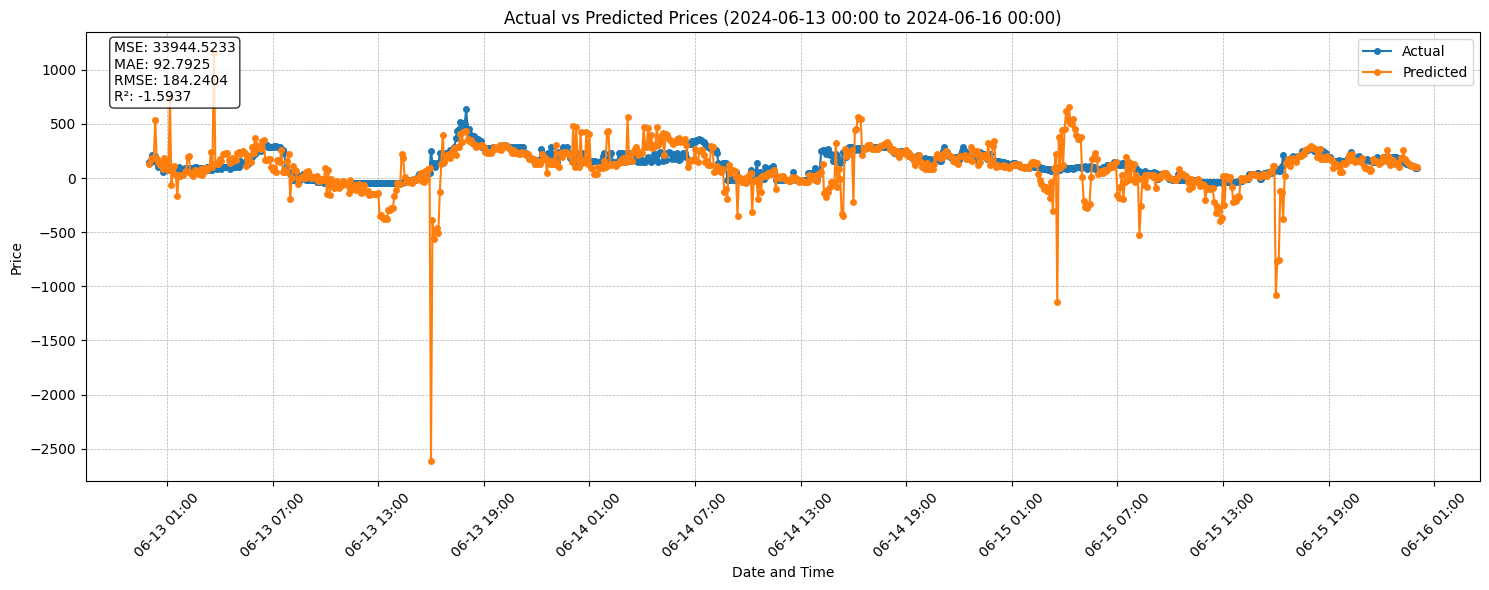

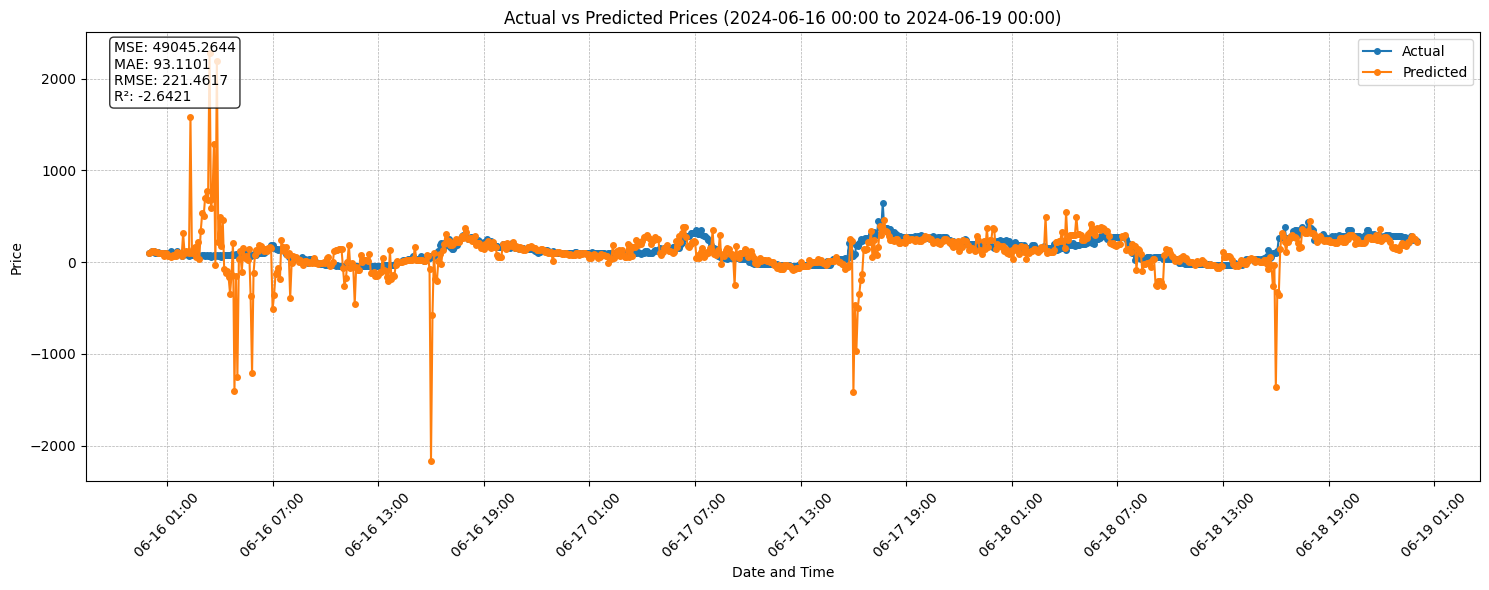

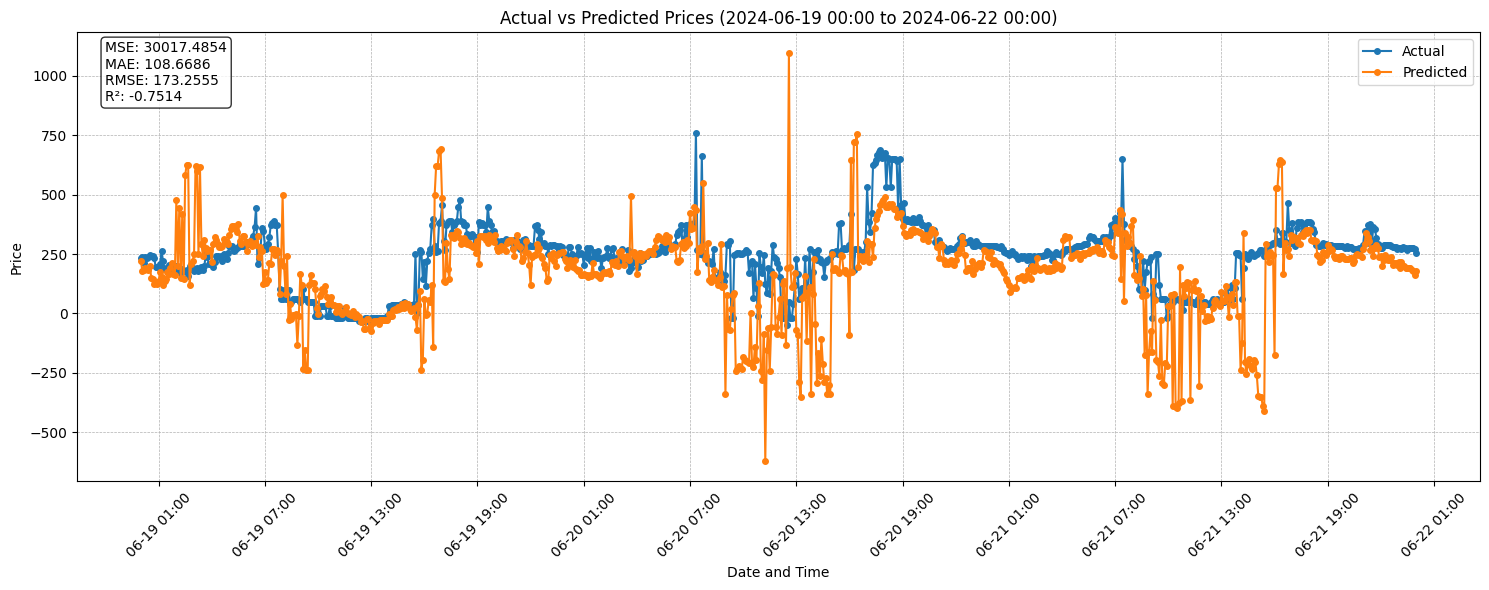

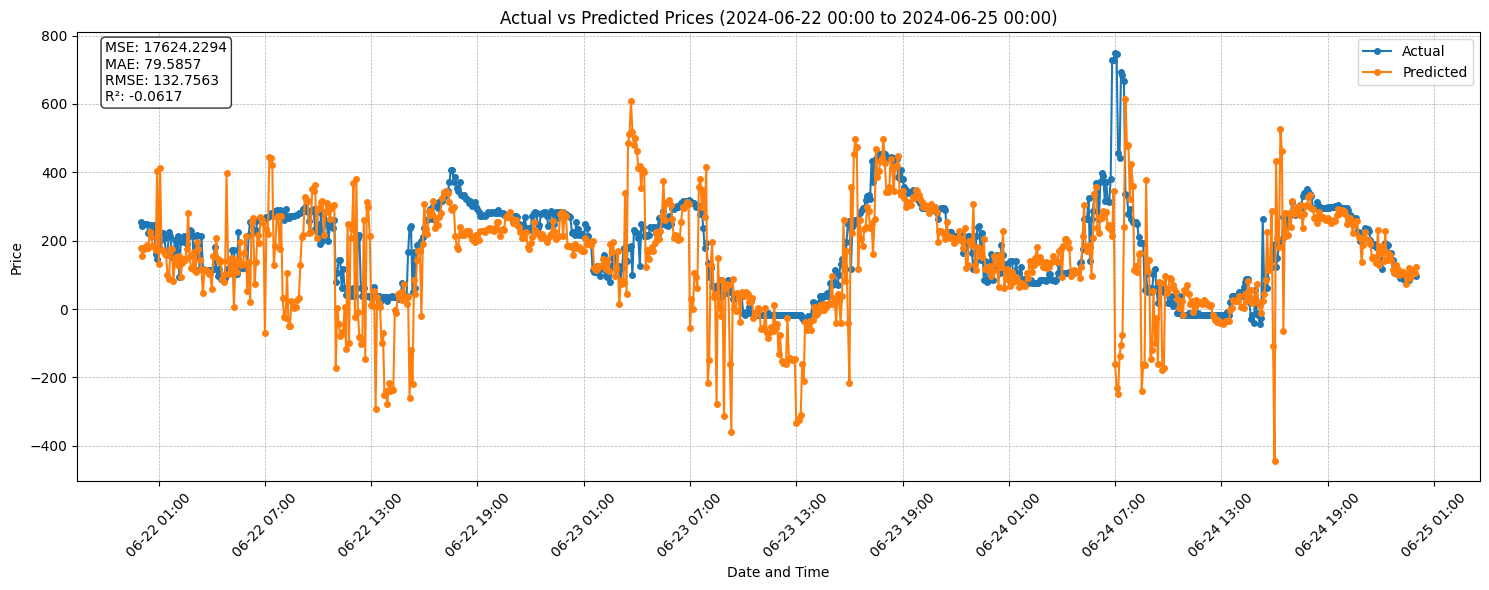

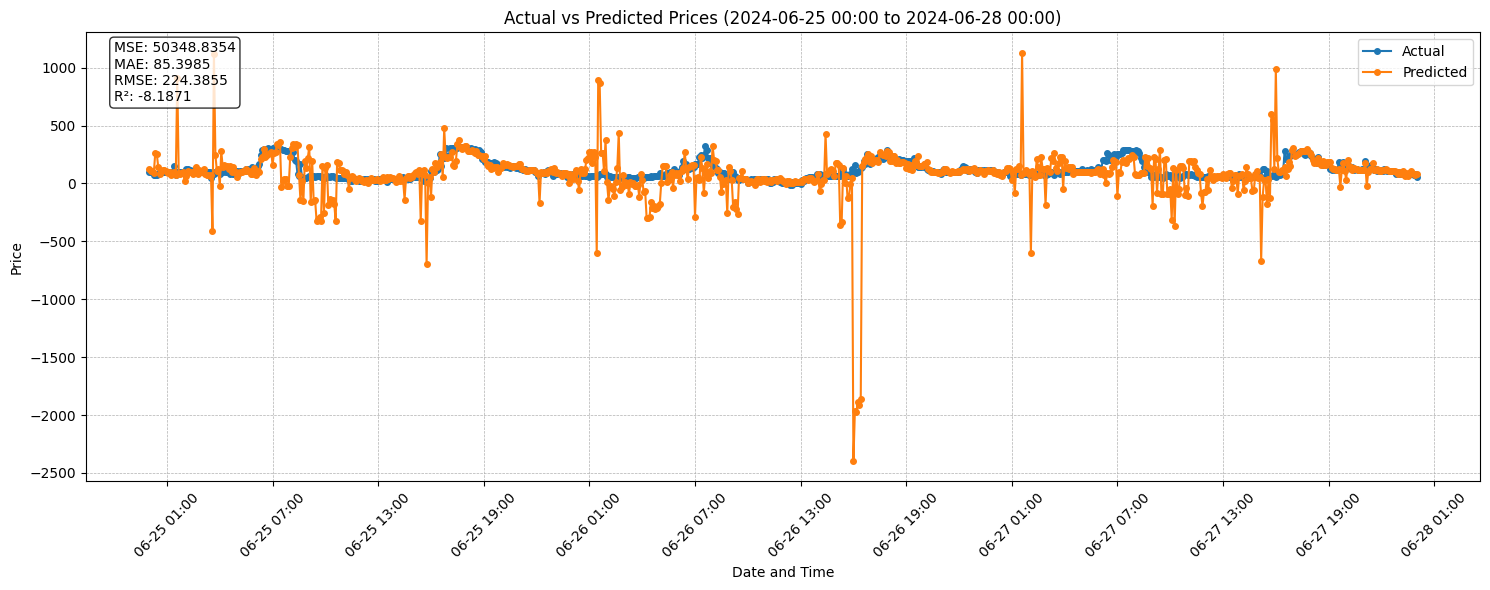

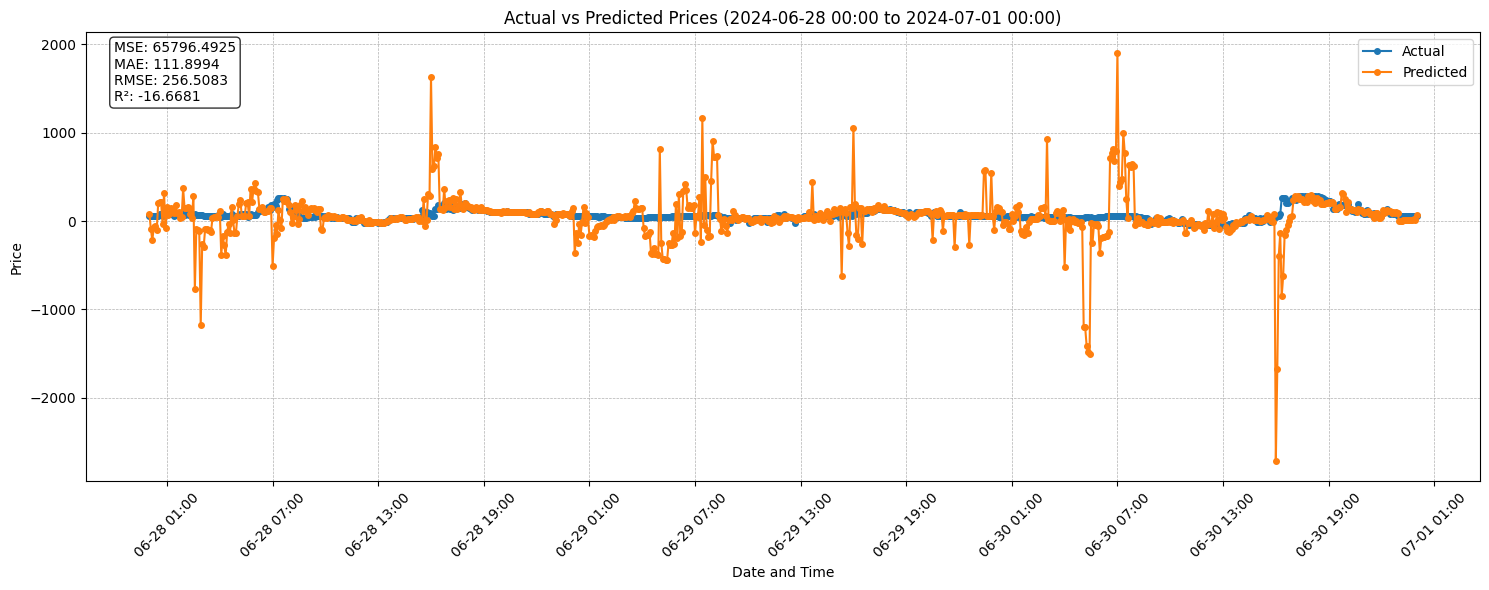

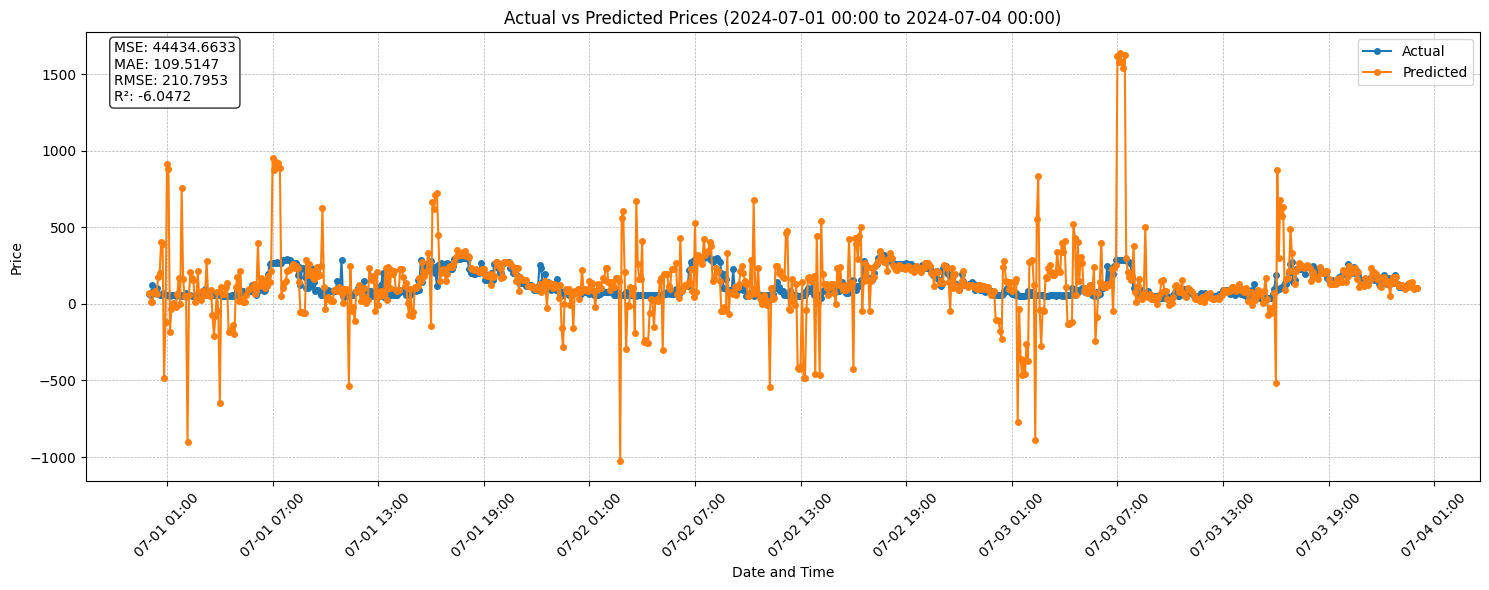

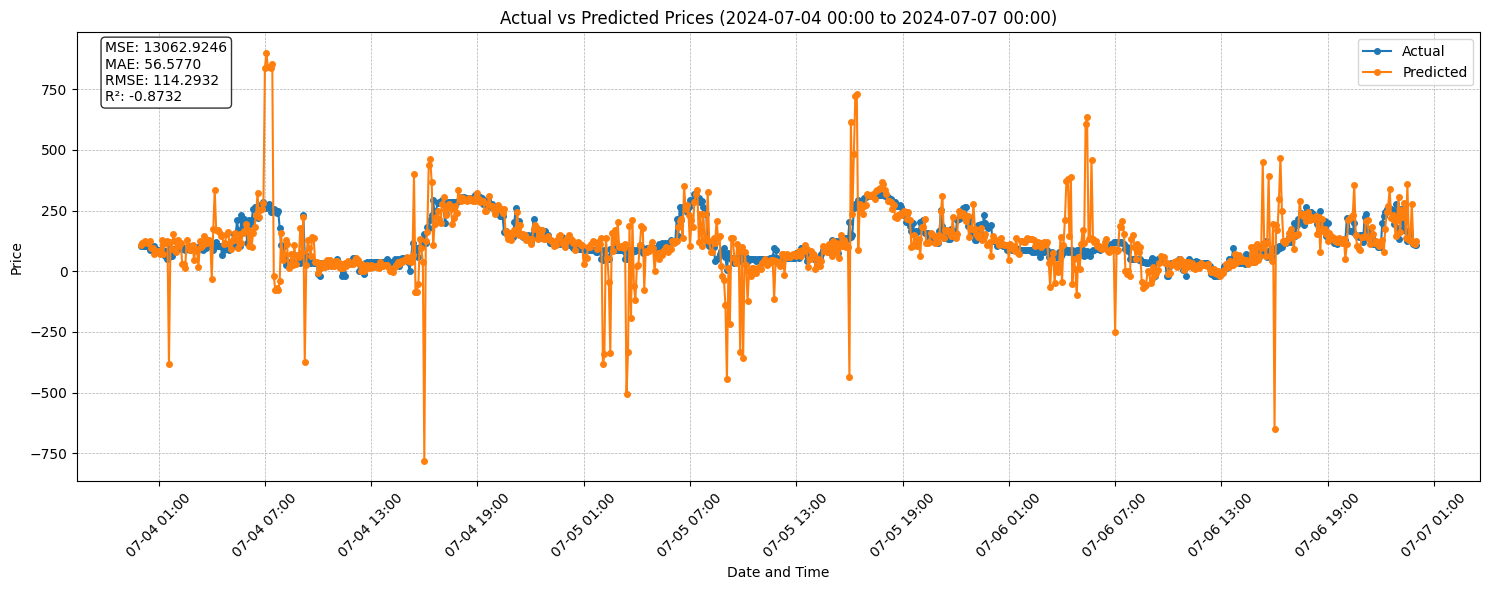

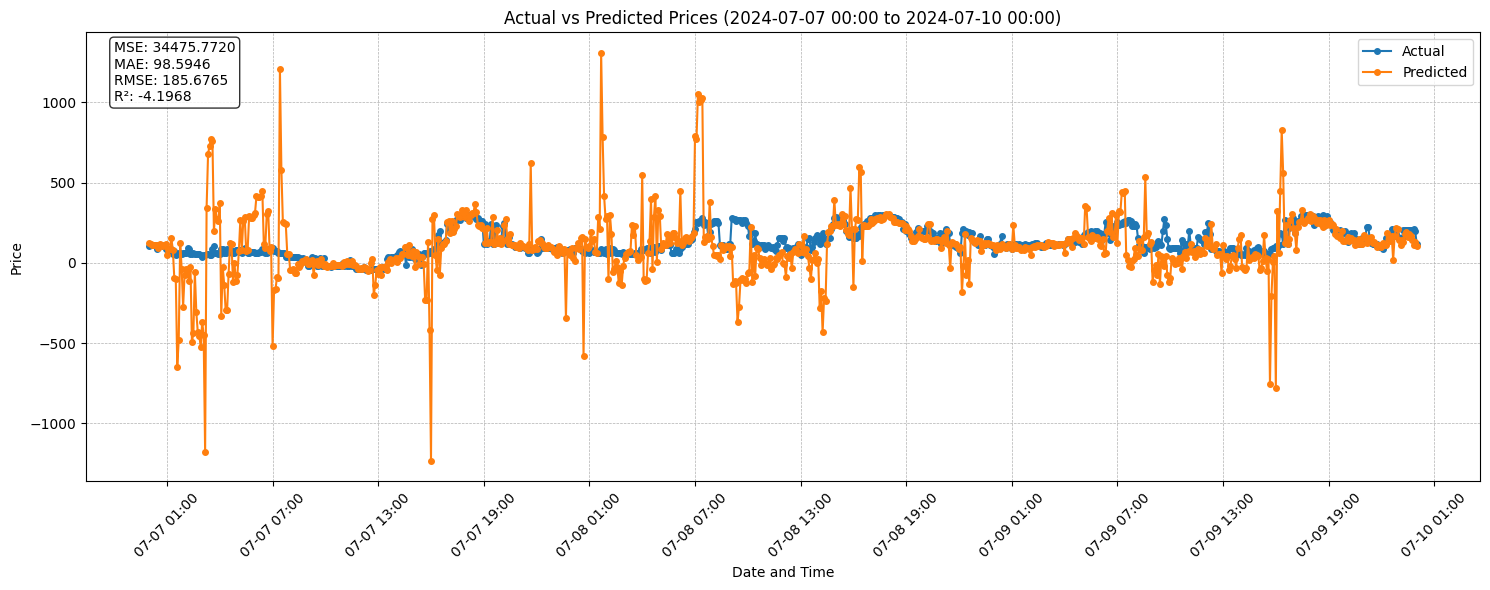

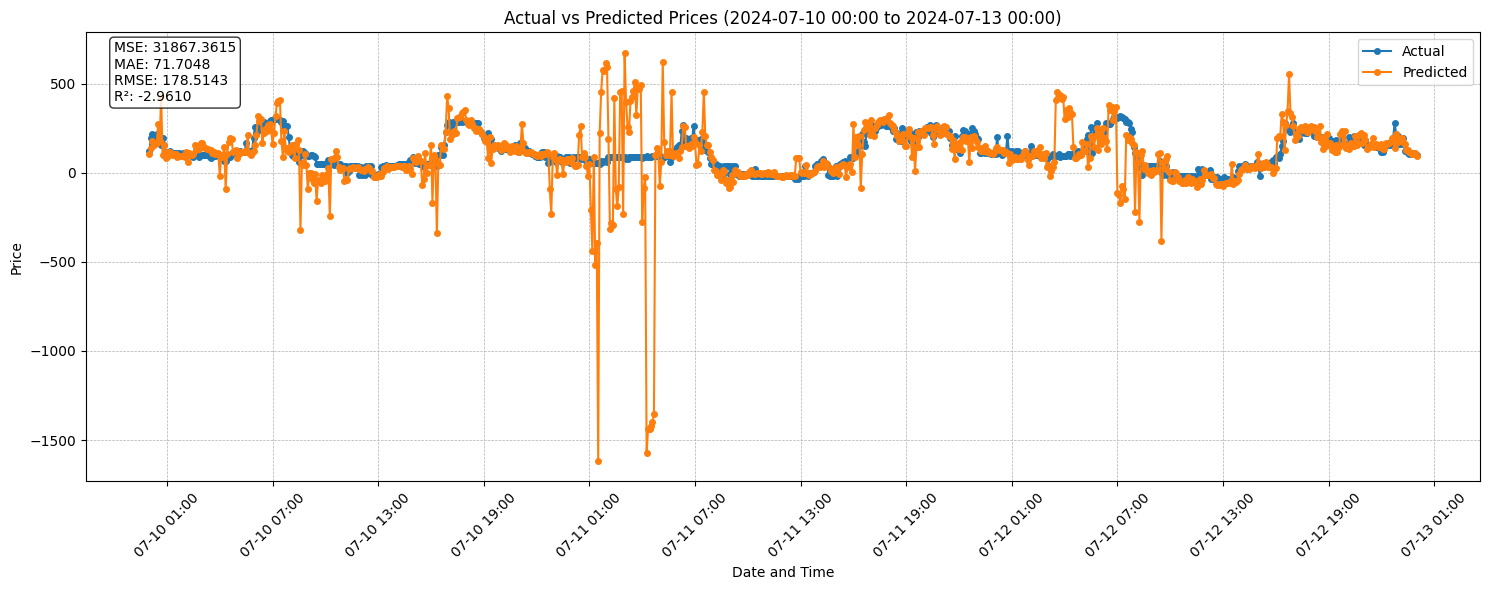

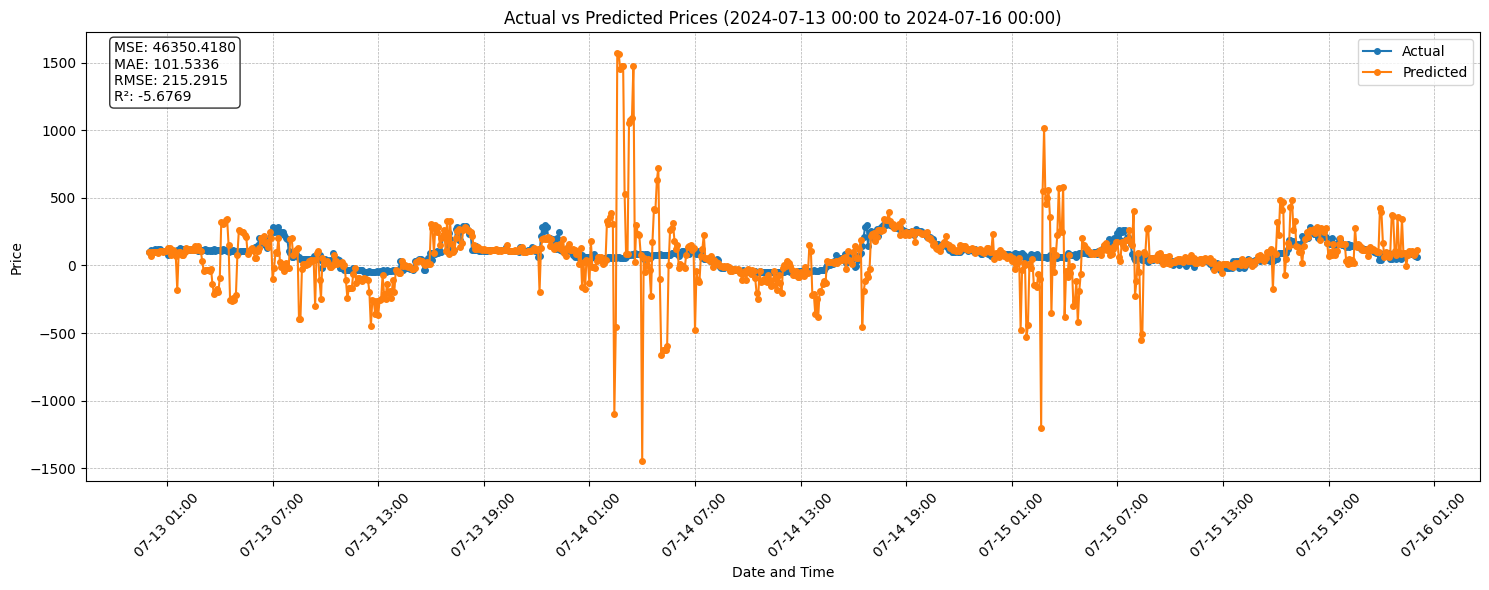

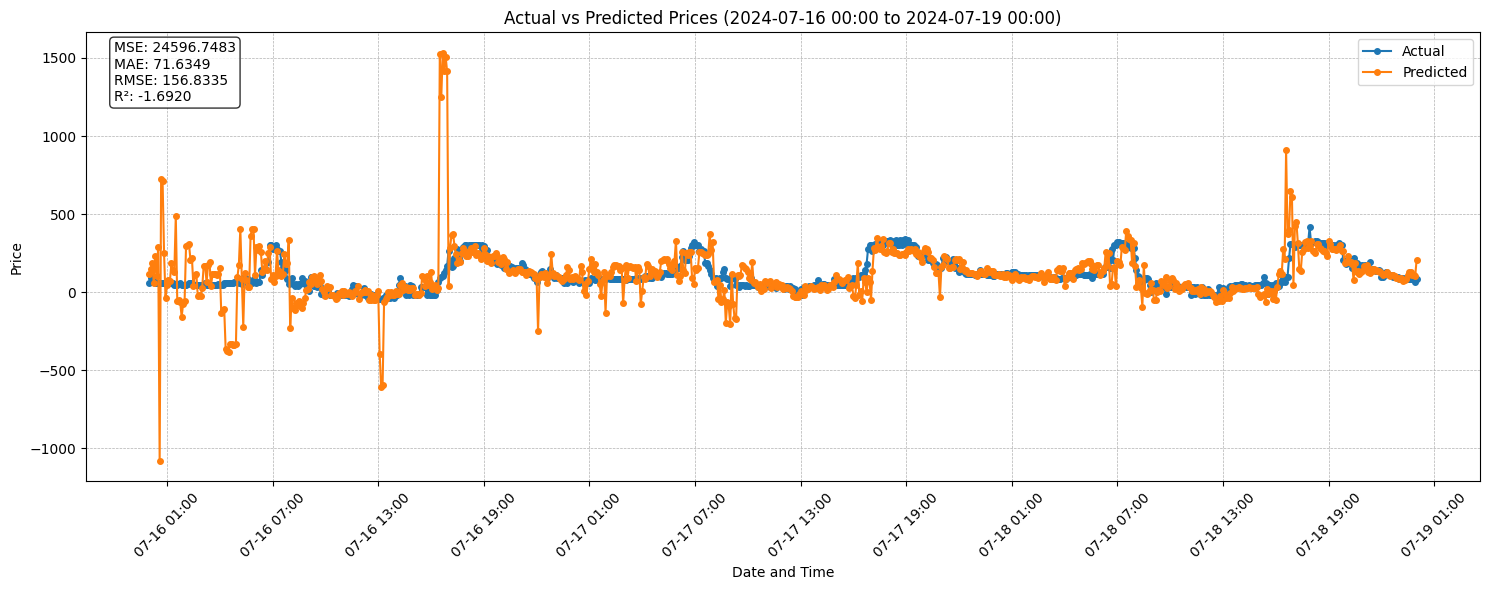

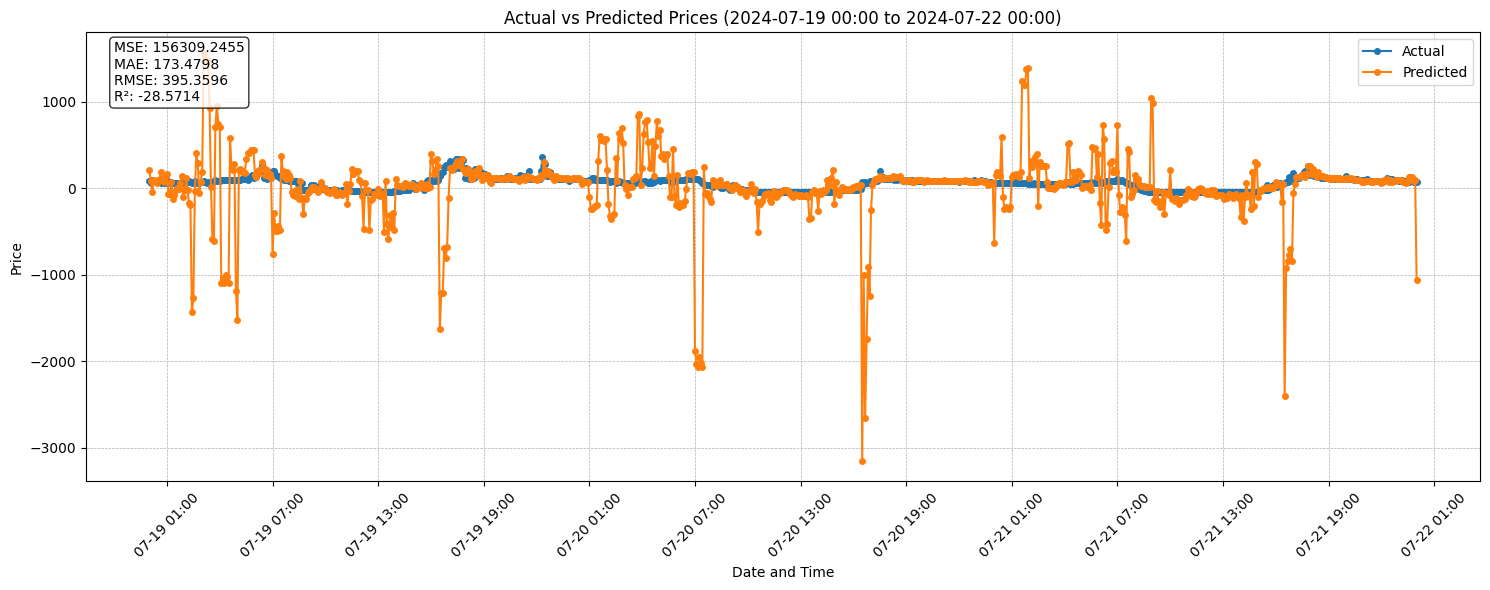

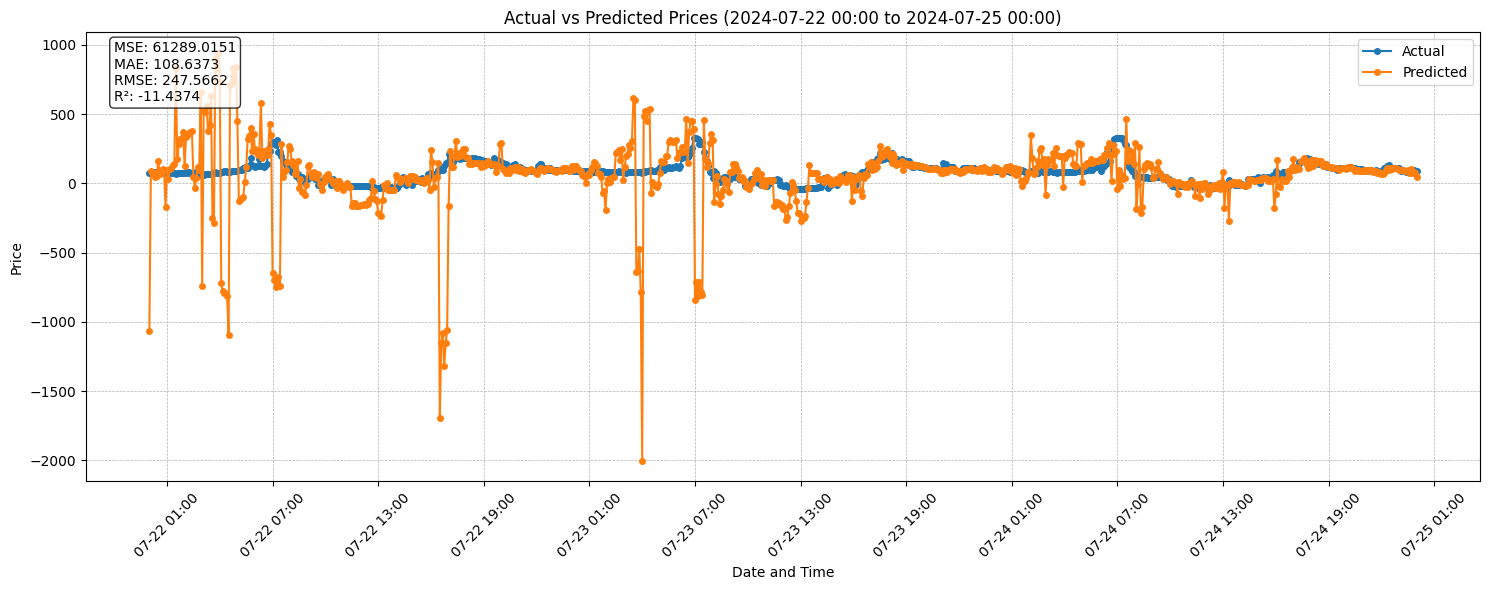

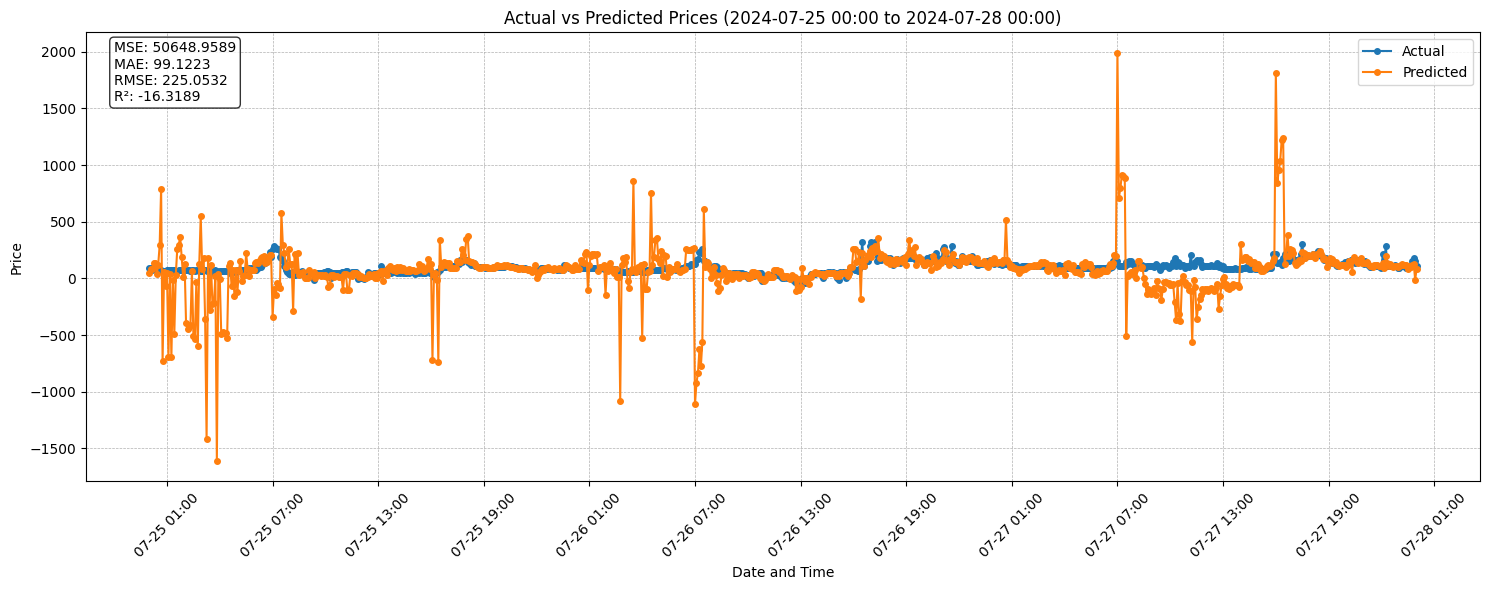

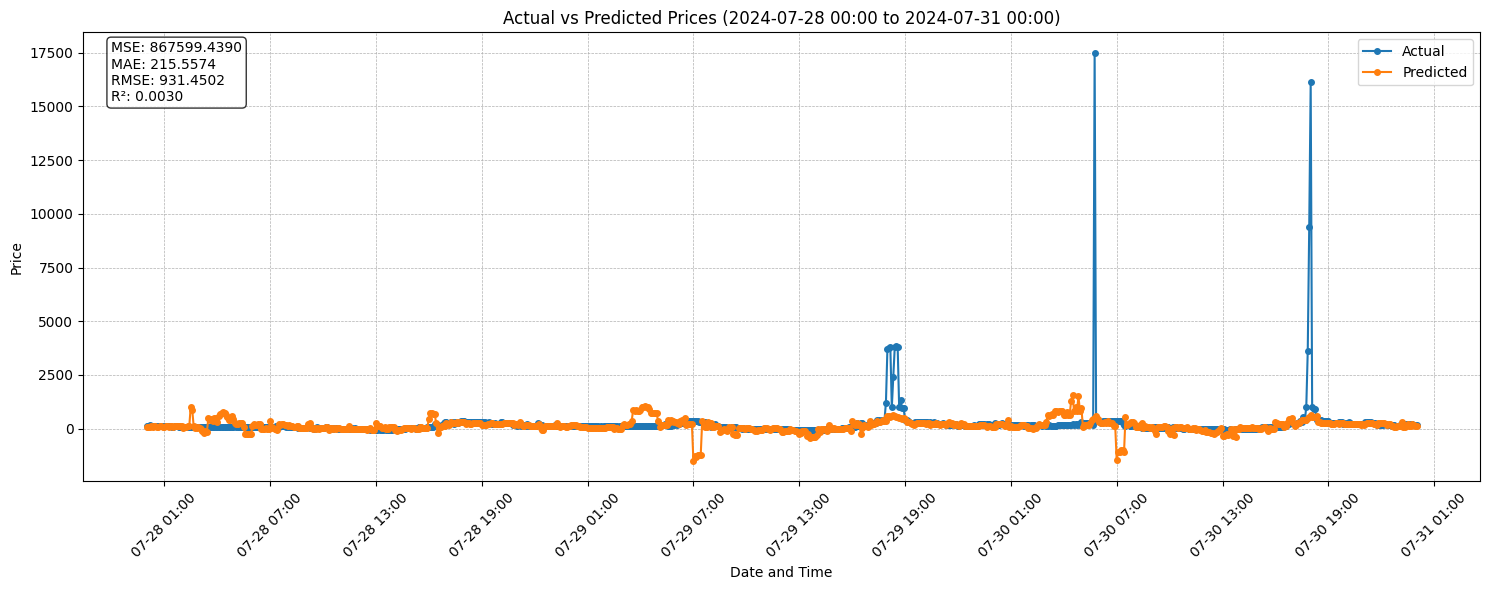

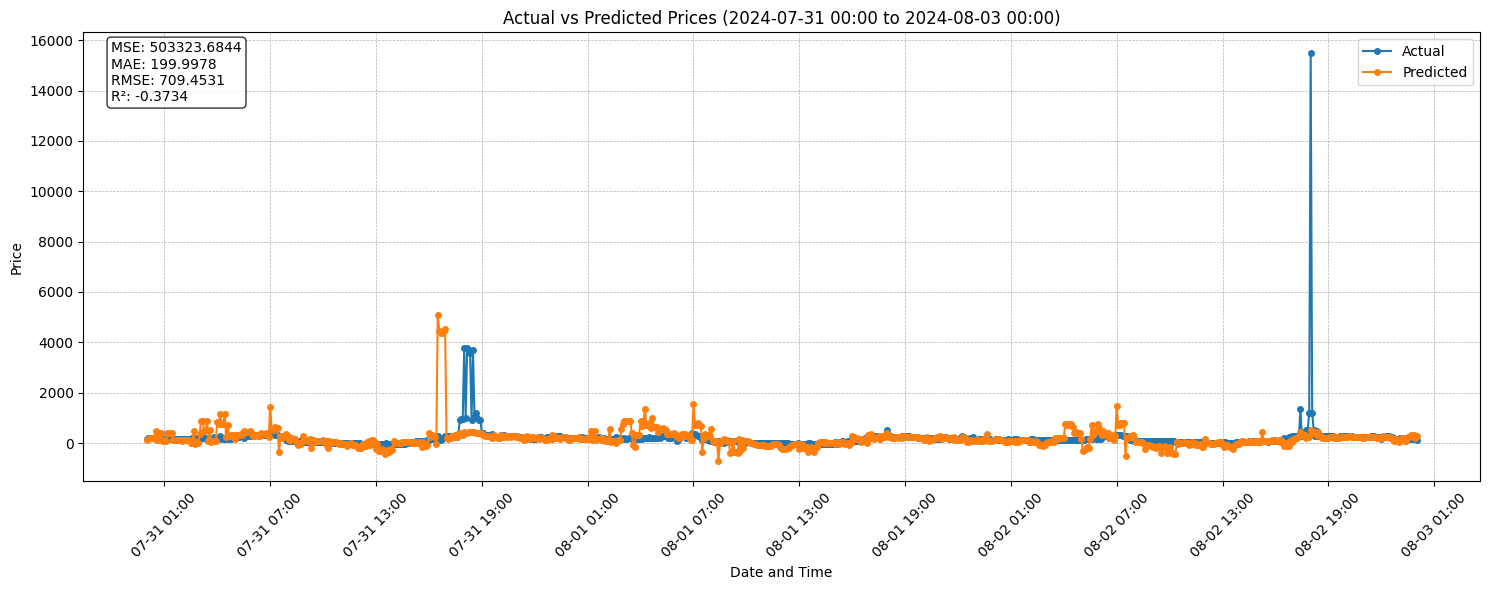

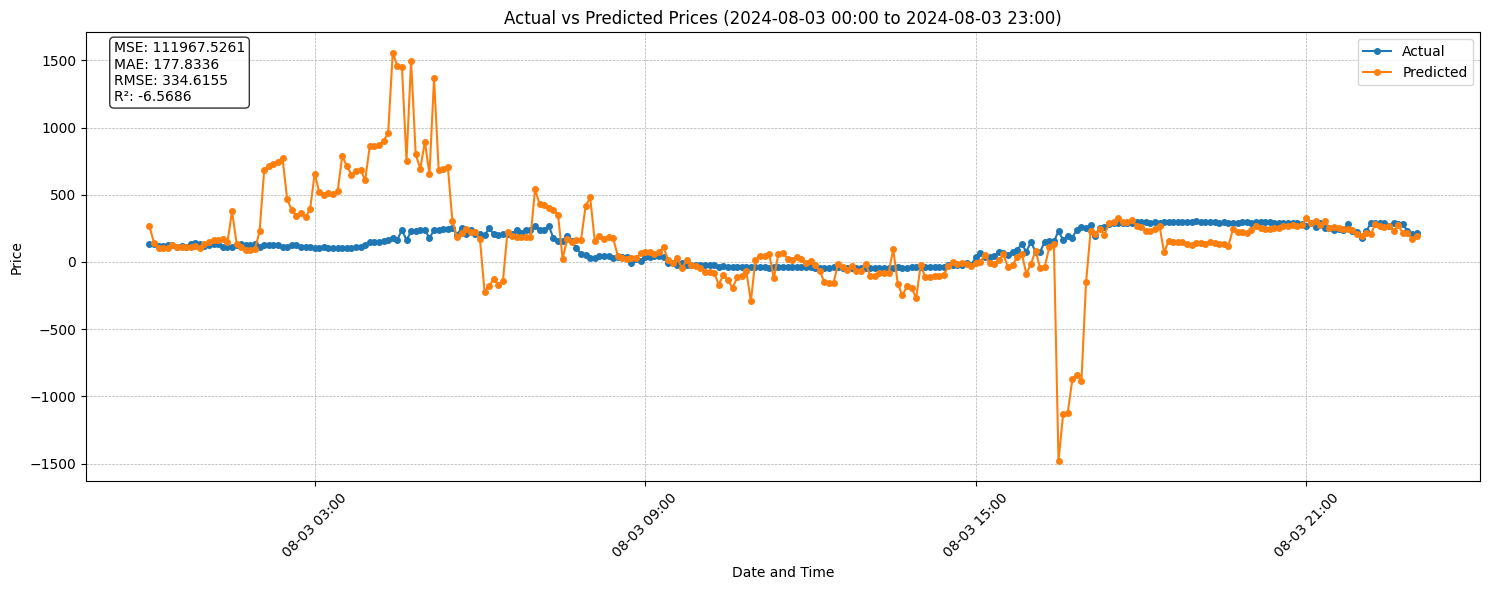

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator, DateFormatter
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

def plot_three_day_comparison(data, start_date, end_date):
    period_data = data.loc[start_date:end_date]
    
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(period_data.index, period_data['Actual'], label='Actual', marker='o', markersize=4)
    ax.plot(period_data.index, period_data['Predicted'], label='Predicted', marker='o', markersize=4)
    
    ax.set_title(f'Actual vs Predicted Prices ({start_date.strftime("%Y-%m-%d %H:%M")} to {end_date.strftime("%Y-%m-%d %H:%M")})')
    ax.set_xlabel('Date and Time')
    ax.set_ylabel('Price')
    ax.legend()
    
    
    ax.xaxis.set_major_locator(HourLocator(interval=6))  
    ax.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))  
    
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
   
    mse = mean_squared_error(period_data['Actual'], period_data['Predicted'])
    mae = mean_absolute_error(period_data['Actual'], period_data['Predicted'])
    rmse = np.sqrt(mse)
    r2 = r2_score(period_data['Actual'], period_data['Predicted'])
    
    metrics_text = f'MSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nR²: {r2:.4f}'
    plt.text(0.02, 0.98, metrics_text, transform=ax.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.show()


start_date = results_df.index.min()
end_date = results_df.index.max()

# three day intervals
current_date = start_date
while current_date <= end_date:
    period_end = min(current_date + pd.Timedelta(days=3), end_date)
    plot_three_day_comparison(results_df, current_date, period_end)
    current_date += pd.Timedelta(days=3)


# mse = mean_squared_error(results_df['Actual'], results_df['Predicted'])
# mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
# rmse = np.sqrt(mse)
# r2 = r2_score(results_df['Actual'], results_df['Predicted'])

# print(f"Overall Performance Metrics:")
# print(f"Mean Squared Error: {mse:.4f}")
# print(f"Mean Absolute Error: {mae:.4f}")
# print(f"Root Mean Squared Error: {rmse:.4f}")
# print(f"R-squared Score: {r2:.4f}")

Hourly Success Rate (sorted from highest to lowest):
hour
21    0.501302
20    0.472656
19    0.449219
18    0.421875
17    0.410156
22    0.380208
23    0.359313
0     0.251302
6     0.174479
5     0.144531
1     0.131510
16    0.115885
2     0.110677
7     0.089844
14    0.088542
15    0.088542
4     0.067708
3     0.063802
8     0.059896
11    0.059896
13    0.059896
12    0.059896
10    0.057292
9     0.052083
Name: is_successful, dtype: float64


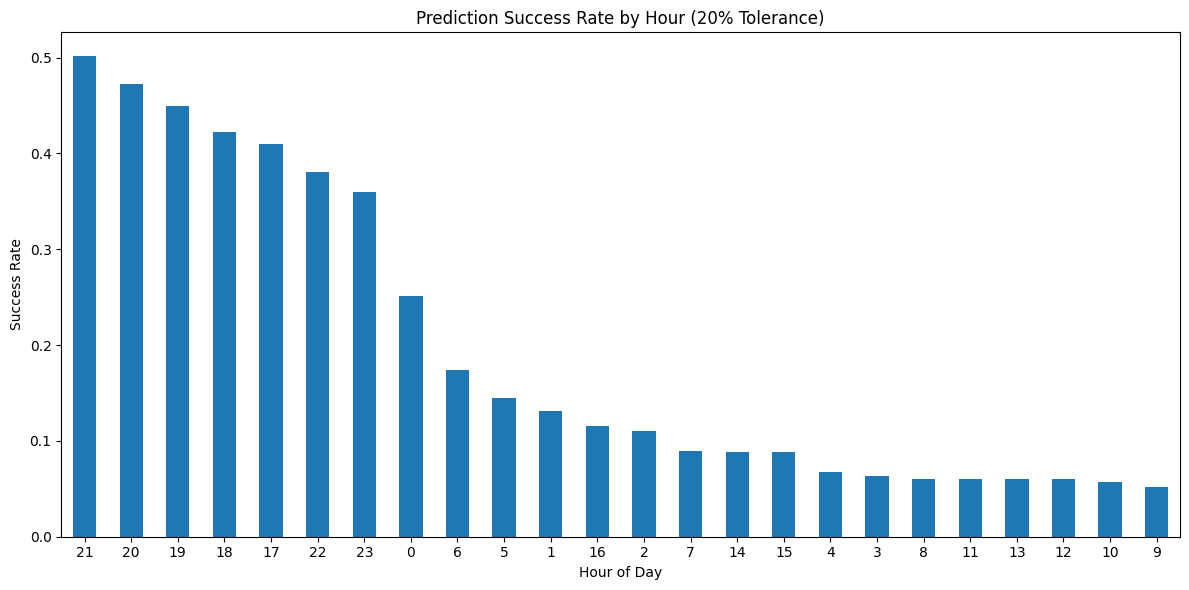

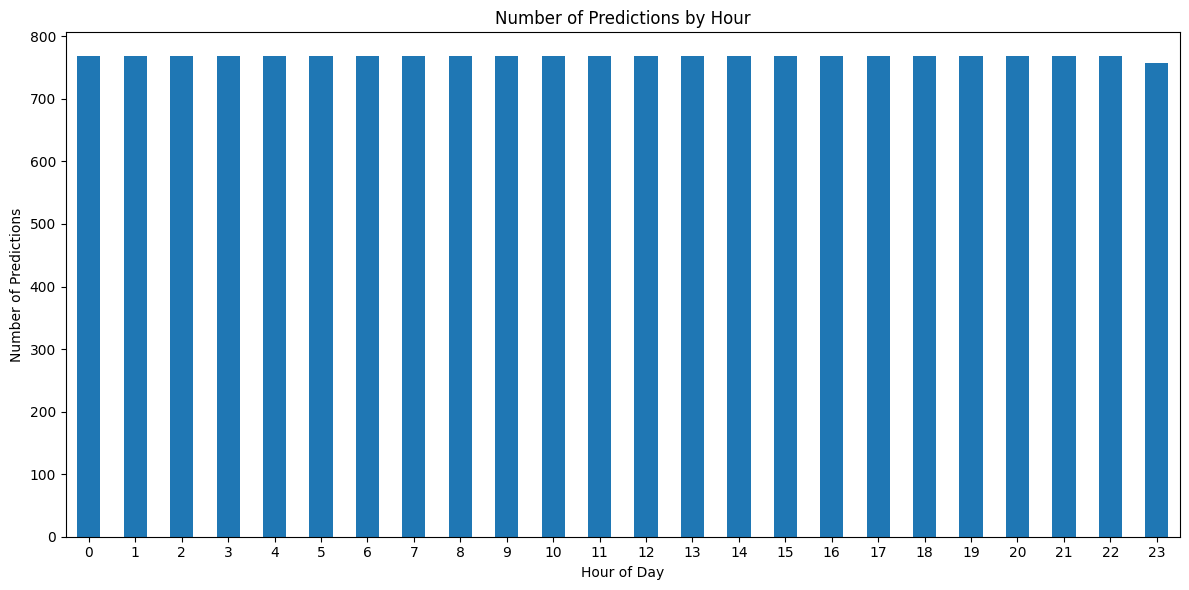


Top 5 hours with highest success rate:
hour
21    0.501302
20    0.472656
19    0.449219
18    0.421875
17    0.410156
Name: is_successful, dtype: float64

Bottom 5 hours with lowest success rate:
hour
9     0.052083
10    0.057292
8     0.059896
11    0.059896
13    0.059896
Name: is_successful, dtype: float64

Overall Success Rate: 19.45%


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



def is_prediction_successful(actual, predicted, tolerance=0.1):
    return abs(predicted - actual) <= abs(actual * tolerance)


results_df['is_successful'] = results_df.apply(lambda row: is_prediction_successful(row['Actual'], row['Predicted']), axis=1)


results_df['hour'] = results_df.index.hour
hourly_success_rate = results_df.groupby('hour')['is_successful'].mean().sort_values(ascending=False)


hourly_prediction_count = results_df.groupby('hour').size()


print("Hourly Success Rate (sorted from highest to lowest):")
print(hourly_success_rate)


plt.figure(figsize=(12, 6))
hourly_success_rate.plot(kind='bar')
plt.title('Prediction Success Rate by Hour (20% Tolerance)')
plt.xlabel('Hour of Day')
plt.ylabel('Success Rate')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
hourly_prediction_count.plot(kind='bar')
plt.title('Number of Predictions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Predictions')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


top_5_hours = hourly_success_rate.nlargest(5)
bottom_5_hours = hourly_success_rate.nsmallest(5)

print("\nTop 5 hours with highest success rate:")
print(top_5_hours)

print("\nBottom 5 hours with lowest success rate:")
print(bottom_5_hours)


overall_success_rate = results_df['is_successful'].mean()
print(f"\nOverall Success Rate: {overall_success_rate:.2%}")

# 繪製成功率和預測次數的組合圖
# fig, ax1 = plt.subplots(figsize=(15, 6))

# ax1.bar(hourly_success_rate.index, hourly_success_rate.values, alpha=0.7, color='b', label='Success Rate')
# ax1.set_xlabel('Hour of Day')
# ax1.set_ylabel('Success Rate', color='b')
# ax1.tick_params(axis='y', labelcolor='b')

# ax2 = ax1.twinx()
# ax2.plot(hourly_prediction_count.index, hourly_prediction_count.values, color='r', label='Prediction Count')
# ax2.set_ylabel('Number of Predictions', color='r')
# ax2.tick_params(axis='y', labelcolor='r')

# plt.title('Prediction Success Rate and Count by Hour')
# fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
# plt.tight_layout()
# plt.show()

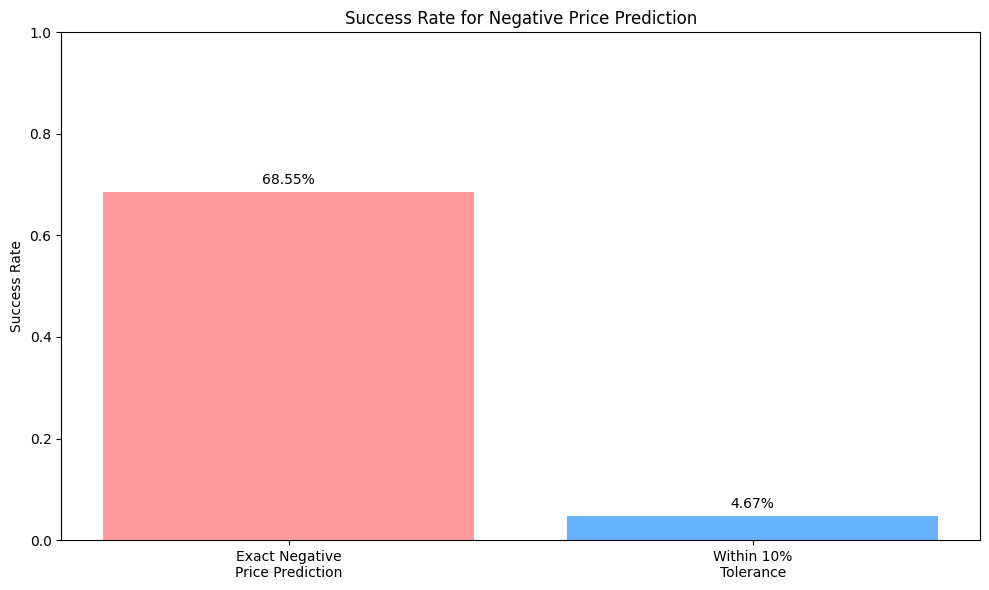

Exact Negative Price Prediction Success Rate: 68.55%
Negative Price Prediction Success Rate (10% Tolerance): 4.67%
Frequency of Negative Prices: 12.79%


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def is_prediction_successful(actual, predicted, tolerance=0.1):
    return abs(predicted - actual) <= abs(actual * tolerance)


results_df['is_successful'] = results_df.apply(lambda row: is_prediction_successful(row['Actual'], row['Predicted']), axis=1)


def analyze_negative_price_prediction(df):
    negative_price_df = df[df['Actual'] < 0]
    

    exact_success = ((negative_price_df['Predicted'] < 0) & (negative_price_df['Actual'] < 0)).mean()

    tolerance_success = negative_price_df['is_successful'].mean()
    
    return exact_success, tolerance_success


exact_success_rate, tolerance_success_rate = analyze_negative_price_prediction(results_df)


plt.figure(figsize=(10, 6))
success_rates = [exact_success_rate, tolerance_success_rate]
labels = ['Exact Negative\nPrice Prediction', 'Within 10%\nTolerance']
colors = ['#FF9999', '#66B2FF']

plt.bar(labels, success_rates, color=colors)
plt.title('Success Rate for Negative Price Prediction')
plt.ylabel('Success Rate')
plt.ylim(0, 1)  


for i, v in enumerate(success_rates):
    plt.text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


print(f"Exact Negative Price Prediction Success Rate: {exact_success_rate:.2%}")
print(f"Negative Price Prediction Success Rate (10% Tolerance): {tolerance_success_rate:.2%}")


negative_price_frequency = (results_df['Actual'] < 0).mean()
print(f"Frequency of Negative Prices: {negative_price_frequency:.2%}")